In [1]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import tf_utils
import time

%matplotlib inline
np.random.seed(1)

In [26]:
# 计算时间
def subtime(date1, date2):
    date1 = datetime.datetime.strptime(date1, "%Y-%m-%d %H:%M:%S")
    date2 = datetime.datetime.strptime(date2, "%Y-%m-%d %H:%M:%S")
    return date2 - date1

In [27]:
# softmax的交叉熵损失

y_hat = tf.constant(36,name="y_hat")
y = tf.constant(39,name="y")

loss = tf.Variable((y-y_hat)**2,name = "loss")  

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print(sess.run(loss))



9


In [42]:
def linear_function():
    """
        参数：
            无
        
        返回：
            result - 通过构建的线性方程(Y = XW + b)计算出来的结果 
        
    """
    np.random.seed(1)
    
    # x.shape=[3,1],w.shape=[4,3],b.shape=[4,1]  
    # x模拟输入层[特征值，样本数]，w为权重[l^(i),l^(i-1)],b为偏移量[l^(i),1]
    
    x = np.random.randn(3,1)
    w = np.random.randn(4,3)
    b = np.random.randn(4,1)
    
    y = tf.add(tf.matmul(w,x),b)
    
    with tf.Session() as sess:
        result = sess.run(y)
        return result

In [29]:
print("y=",linear_function())

y= [[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]]


In [30]:
def sigmoid(z):
    """
        参数：
            z - 用于激活的输入值
            
        返回：
            result - 通过sigmoid激活后的结果
    
    """
    # 直接带入求解    
    # z = tf.cast(z,tf.float16)
    # sigmoid = tf.sigmoid(z)
    # with tf.Session() as sess:
    #      result = sess.run(sigmoid)
    # 占位求解
    x = tf.placeholder(tf.float32,name="x")
    sigmoid = tf.sigmoid(x)
    with tf.Session() as sess:
         result = sess.run(sigmoid,feed_dict={x:z})
    
    return result
    

In [31]:
print("sigmoid(12):",sigmoid(12))

sigmoid(12): 0.9999938


In [32]:
def one(shape):
    """
        参数：
            shape - 需要生成矩阵的形状
        
        返回：
            result - 生成都是1的矩阵
    
    """
    
    matrix = tf.ones(shape)
    with tf.Session() as sess:
        result = sess.run(matrix)
    return result

In [33]:
print("one_matrix:",one([3,2]))

one_matrix: [[1. 1.]
 [1. 1.]
 [1. 1.]]


## 加载数据

In [6]:
X_train_orig , Y_train_orig , X_test_orig , Y_test_orig , classes = tf_utils.load_dataset()

In [35]:
# 查看数据
print("x_train:",X_train_orig.shape)
print("y_train:",Y_train_orig.shape)
print("x_test:",X_test_orig.shape)
print("y_test:",Y_test_orig.shape)
print("classes:",classes)

x_train: (1080, 64, 64, 3)
y_train: (1, 1080)
x_test: (120, 64, 64, 3)
y_test: (1, 120)
classes: [0 1 2 3 4 5]


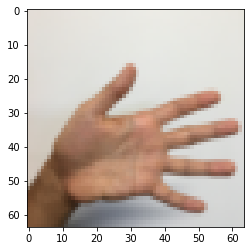

In [36]:
# 图片内容
plt.imshow(X_train_orig[0])
plt.show()

In [7]:
# 将数据展开，用于tf计算
X_train_flatten = X_train_orig.reshape([X_train_orig.shape[0],-1]).T
X_test_flatten = X_test_orig.reshape([X_test_orig.shape[0],-1]).T
# reshape不能乱用，特别是对于图片像素来说，需要根据每张图片的固定顺序来调整，否则会出现乱码

X_train = X_train_flatten / 255
X_test = X_test_flatten / 255
# 转one-hot编码
Y_train = tf_utils.convert_to_one_hot(Y_train_orig,6)
Y_test = tf_utils.convert_to_one_hot(Y_test_orig,6)

In [38]:
# np.eye生成对角为1的矩阵，根据（）里的决定生成个数
np.eye(6)[[1,4]]

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [39]:
print("x_train:",X_train.shape)
print("y_train:",Y_train.shape)
print("x_test:",X_test.shape)
print("y_test:",Y_test.shape)

x_train: (12288, 1080)
y_train: (6, 1080)
x_test: (12288, 120)
y_test: (6, 120)


## 设置模型

In [9]:
# 初始化参数
def initialize_params(shape_w,shape_b,num):
    """
        参数：
            shape_w - 该层的权重形状
            shape_b - 该层的偏置形状
            num - 层编号
            
        返回：
            w - 初始化后的权重
            b - 初始化后的偏置
    
    """
    tf.set_random_seed(1)
    
    w = tf.get_variable("W"+str(num),shape=shape_w,initializer=tf.contrib.layers.xavier_initializer(seed=1))   
    b = tf.get_variable("b"+str(num),shape=shape_b,initializer=tf.zeros_initializer())
    
    return w, b    
    

In [44]:
tf.reset_default_graph() # 用于重置全局默认图形
W2, b2 = initialize_params([12,25],[12,1],2)
W2,b2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



(<tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>,
 <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>)

In [10]:
# 前向传播
def forward_propagation(X):
    """
        参数：
            x - 输入的数据
        
        返回：
            z3 - 最后一次线性回归之后的值
    
    """
    
    
    # 生成每层的变量，进行线性回归和激活
    W1, b1 = initialize_params([25,X.shape[0]],[25,1],1)     
    z1 = tf.add(tf.matmul(W1,X),b1)
    a1 = tf.nn.relu(z1)
    W2, b2 = initialize_params([12,a1.shape[0]],[12,1],2)
    z2 = tf.add(tf.matmul(W2,a1),b2)
    a2 = tf.nn.relu(z2)
    W3, b3 = initialize_params([6,a2.shape[0]],[6,1],3)
    z3 = tf.add(tf.matmul(W3,a2),b3)

    return z3

In [48]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,[12288,None],name = "X")
z3 = forward_propagation(X)
z3

<tf.Tensor 'Add_2:0' shape=(6, ?) dtype=float32>

In [11]:
# 计算损失
def compute_cost(zl,Y):
    """
        参数：
            zl - 最后一层线性回归后的值
            Y - 输入数据的标签
            
        返回：
            loss - 该批次所产生的损失
            
    """
    
    # 需进行转置将形状变为【-1，class】才能调用cross_entropy
    logits = tf.transpose(zl) #转置
    labels = tf.transpose(Y)
   
    # 直接对zl进行了softmax激活，并通过交叉熵进行求损失
    loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=logits))
    
    return loss

In [49]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,[12288,None],name = "X")
Y = tf.placeholder(tf.float32,[6,None],name = "Y")     
z3 = forward_propagation(X)
cost = compute_cost(z3,Y)
cost

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [ ]:
# backward propagation
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

In [21]:
# 建立模型
def model(X_train,Y_train,X_test,Y_test,lr=0.0001,epoch=101,batch_size=32,print_cost=True,is_plt=True,for_test=False,model_path=None):
    """
        参数：
            X_train - 训练输入的数据
            Y_train - 训练数据的标签
            X_test - 测试的输入数据
            Y_test - 测试数据的标签
            lr - 学习率
            epoch - 迭代次数
            batch_size - 一批次的数据大小
            print_cost - 每100次迭代打印一次损失
            is_plt - 画损失图像
            for_test - 用于预测
            model_path - 加载模型的地址
    
    """
    
    ops.reset_default_graph() #能够重新运行模型而不覆盖tf变量
    tf.set_random_seed(1)
    seed = 3
    costs = []
    
    # 设置占位符
    x = tf.placeholder(tf.float32,[12288,None],name = "x")
    y = tf.placeholder(tf.float32,[6,None],name = "y")
    # 样本数
    m = Y_train.shape[1]
    # forward_propagation
    
    zl = forward_propagation(x)
    cost = compute_cost(zl, y)
    
    # backward_propagation
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    
    # 计算准确率
    correct_list = tf.equal(tf.argmax(zl,axis=0),tf.argmax(y,axis=0))
    acc = tf.reduce_mean(tf.cast(correct_list,tf.float32))
    #初始化所有变量
    init = tf.global_variables_initializer()
    
    # 储存模型，可以直接，在当前图中加载储存的参数，且需要写出变量定义
    model_save = tf.train.Saver()
    with tf.Session() as sess:
        if for_test:
            model_save.restore(sess,model_path)
            pre_y=sess.run(zl,feed_dict={x:X_test})
            print("预测结果为：", tf.argmax(pre_y,axis=0).eval())
        
        else:
            sess.run(init)
        
            # 开始训练
            for i in range(epoch):
                # 获取批次数据,seed用于每次迭代打乱数据
                seed = seed + 1
                minibatches = tf_utils.random_mini_batches(X_train,Y_train,batch_size,seed)
                num_minibatches = int(m / batch_size)
                # 每一代的误差
                epoch_cost = 0

                for j in minibatches:
                    # j 是其中一个batch包含（minibatch_x,minibatch_y）
                    _, batch_cost = sess.run([optimizer,cost],feed_dict={x:j[0],y:j[1]})
                    epoch_cost = epoch_cost + batch_cost / num_minibatches

                if i % 10 ==0:
                    costs.append(epoch_cost)
                    if print_cost and i % 100 == 0:
                        print("第"+str(i)+"次epoch"+": epoch_cost= %f, epoch_acc= %f"%(epoch_cost, acc.eval(feed_dict={x:X_train,y:Y_train})))

            model_save.save(sess,"my_model")
            if is_plt:
                plt.plot(costs)
                plt.ylabel('cost')
                plt.xlabel('epoch (per 10)')
                plt.title("Learning rate =" + str(lr))
                plt.show()

            print("最终训练集的准确率：", acc.eval({x:X_train,y:Y_train}))
            print("最终测试集的准确率:", acc.eval({x: X_test, y: Y_test}))

第0次epoch: epoch_cost= 1.855702, epoch_acc= 0.166667
第100次epoch: epoch_cost= 1.017255, epoch_acc= 0.633333
第200次epoch: epoch_cost= 0.733184, epoch_acc= 0.789815
第300次epoch: epoch_cost= 0.573071, epoch_acc= 0.833333
第400次epoch: epoch_cost= 0.468573, epoch_acc= 0.875000
第500次epoch: epoch_cost= 0.381228, epoch_acc= 0.907407
第600次epoch: epoch_cost= 0.313815, epoch_acc= 0.885185
第700次epoch: epoch_cost= 0.253624, epoch_acc= 0.947222
第800次epoch: epoch_cost= 0.203897, epoch_acc= 0.966667
第900次epoch: epoch_cost= 0.166472, epoch_acc= 0.974074
第1000次epoch: epoch_cost= 0.146867, epoch_acc= 0.972222
第1100次epoch: epoch_cost= 0.107288, epoch_acc= 0.991667
第1200次epoch: epoch_cost= 0.086557, epoch_acc= 0.987963
第1300次epoch: epoch_cost= 0.059360, epoch_acc= 0.997222
第1400次epoch: epoch_cost= 0.052275, epoch_acc= 0.998148


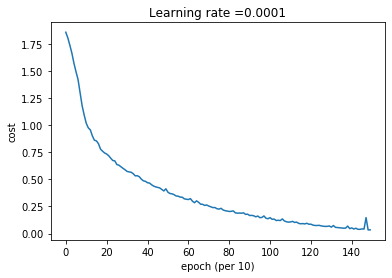

最终训练集的准确率： 0.9990741
最终测试集的准确率: 0.725
CPU运行时间： 0:07:47


In [184]:
import datetime
# 开始时间
start=datetime.datetime.now()
start=start.strftime("%Y-%m-%d %H:%M:%S")
# 训练
model(X_train, Y_train, X_test, Y_test)
# 结束时间
end=datetime.datetime.now()
end=end.strftime("%Y-%m-%d %H:%M:%S")

print("CPU运行时间：", subtime(start,end))

INFO:tensorflow:Restoring parameters from ./model/
预测结果为： [5]


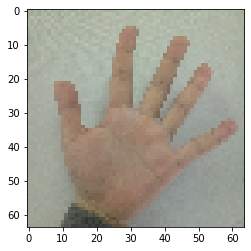

In [22]:
#加载测试数据
import matplotlib.image as mpimg # mpimg 用于读取图片
import os
my_image1 = "5.png"                                            #定义图片名称
fileName1 = "datasets/fingers/" + my_image1                      #图片地址
image1 = mpimg.imread(fileName1)                               #读取图片
plt.imshow(image1)                                             #显示图片
my_image1 = image1.reshape(1,64 * 64 * 3).T     
# 加载模型,
model(X_train, Y_train, my_image1, Y_test,for_test=True,model_path="./model/")
